# Imports

In [130]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


# Set Paths

In [131]:
# Define the project path and a list of 5 ABF file names
project_path = 'C:\\Users\\ikmor\\OneDrive\\Documents\\SNR AND OBR pilot study\\'

abf_files_set1 = [
    f'{project_path}PTX10 CNQX A3.abf',
    f'{project_path}DS5L4 ACCOM.abf',
    f'{project_path}DS5R2 ACCOM.abf',
    f'{project_path}DS4 ACCOM.abf'
]
abf_files_set2 = [
    f'{project_path}PTX10 CNQX APPLIED A3.abf',
    f'{project_path}DS5L4CNQX ACCOM.abf',
    f'{project_path}DS5R2 CNQX ACCOM.abf',
    f'{project_path}DS4CNQX ACCOM.abf']



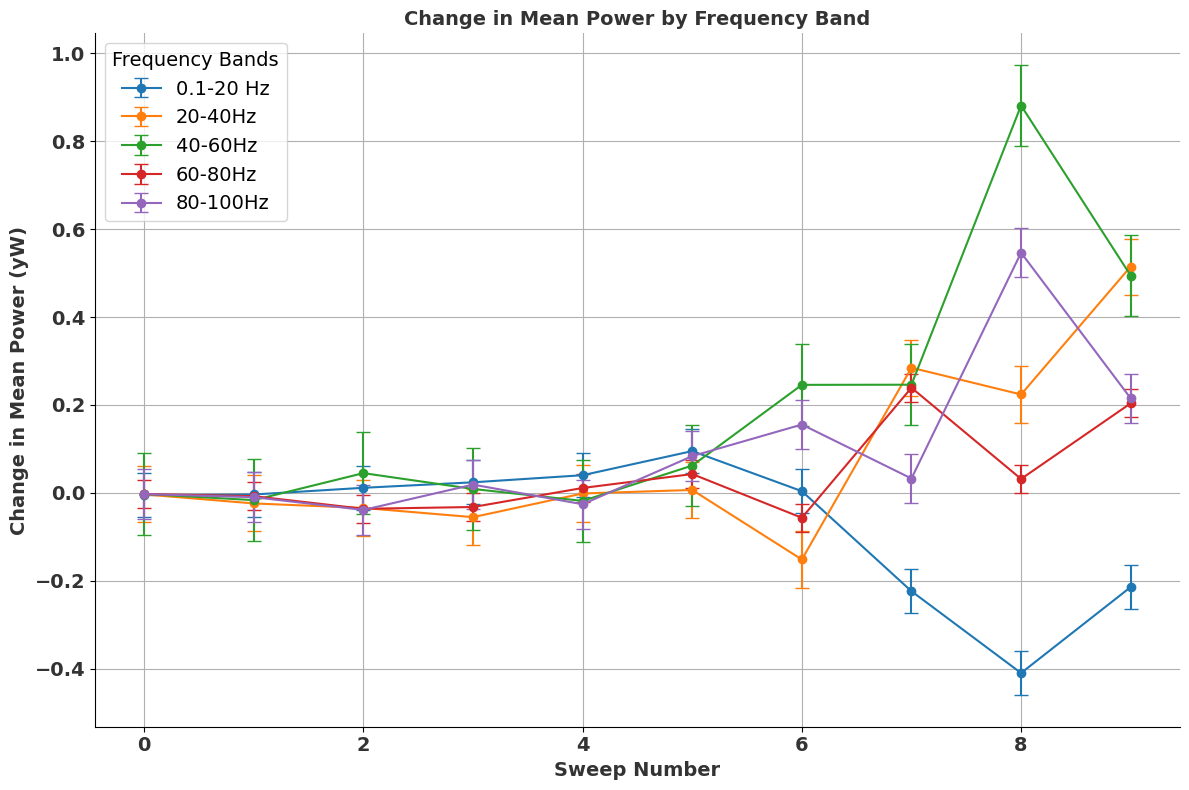

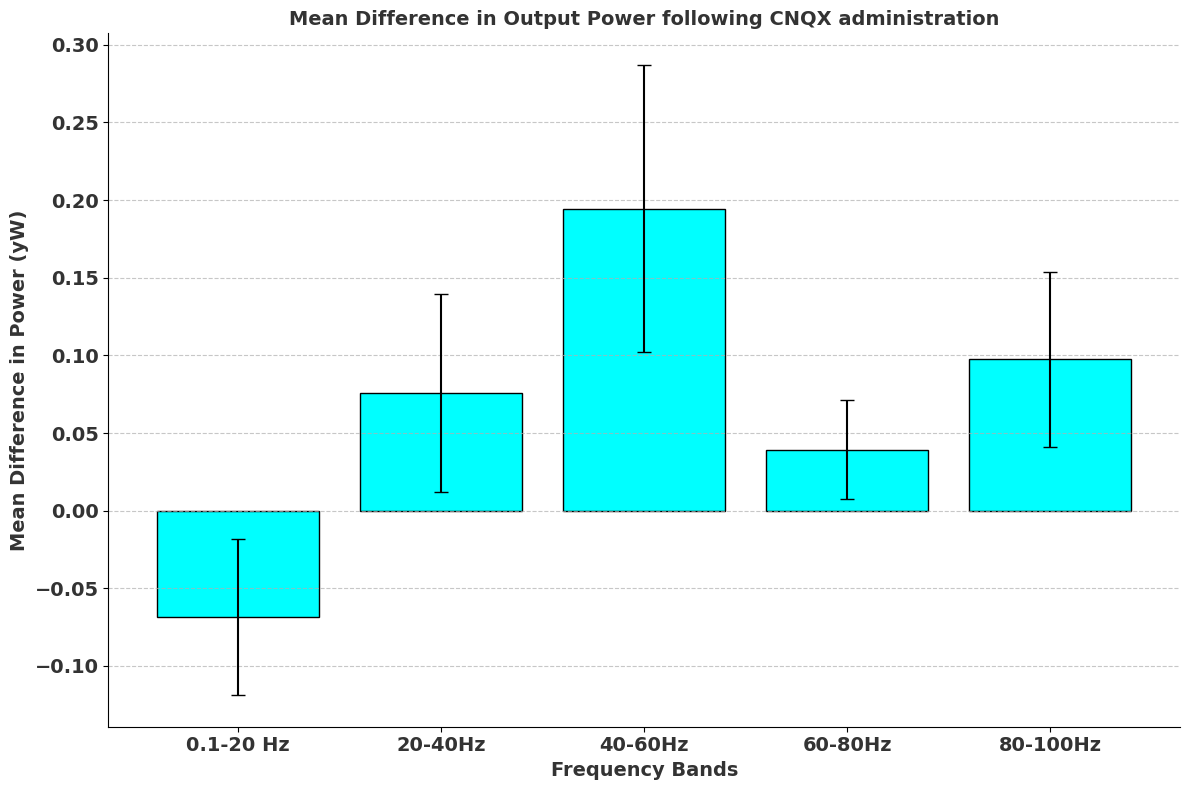

Mean Power Differences and Standard Errors for Each Frequency Band:
0.1-20 Hz: Mean = -6.837012e-02 yW, SE = 5.044200e-02 yW
20-40Hz: Mean = 7.589337e-02 yW, SE = 6.381830e-02 yW
40-60Hz: Mean = 1.945184e-01 yW, SE = 9.251350e-02 yW
60-80Hz: Mean = 3.921513e-02 yW, SE = 3.195087e-02 yW
80-100Hz: Mean = 9.738195e-02 yW, SE = 5.625945e-02 yW


In [132]:

# Process files to get sweep powers
def process_file(file_name):
    sweep_powers = [[] for _ in range(10)]  # 10 sweeps
    LJP = 13  # Liquid Junction Potential in mV

    abf = pyabf.ABF(file_name)
    
    for sweep in range(10):
        abf.setSweep(sweep, channel=0)
        
        start_time, end_time = 3.2, 4.1  # Time segment for analysis (in seconds)
        voltage = abf.sweepY - LJP  # Voltage in mV
        times = abf.sweepX  # Time in seconds
        current_command = abf.sweepC  # Current in pA

        start_index = np.argmin(np.abs(times - start_time))
        end_index = np.argmin(np.abs(times - end_time))

        segment_voltage = voltage[start_index:end_index]
        segment_current = current_command[start_index:end_index]

        segment_current_A = segment_current * 1e-12
        segment_voltage_V = segment_voltage * 1e-3

        instantaneous_power = segment_voltage_V * segment_current_A

        fs = abf.dataRate  # Sampling frequency
        segment_length_ms = 20
        nperseg = int(fs * segment_length_ms / 1000)
        noverlap = nperseg // 2
        nperseg += nperseg % 2
        nfft = 320000

        f, Pxx = signal.welch(instantaneous_power, fs=fs, window='hann', nperseg=nperseg,
                              noverlap=noverlap, nfft=nfft, scaling='density')

        # Define frequency bands
        bands = [(0.1,20), (20, 40), (40, 60) ,(60,80) ,(80,100)]
        band_powers = []

        for band_start, band_end in bands:
            band_mask = (f >= band_start) & (f < band_end)
            band_power = np.trapz(Pxx[band_mask], f[band_mask])
            band_powers.append(band_power * (end_time - start_time) * 1e24)  # Convert to yoctoWatt

        sweep_powers[sweep] = band_powers

    return np.array(sweep_powers)

def process_file_set(file_list):
    all_powers = []
    for file in file_list:
        all_powers.append(process_file(file))
    return np.array(all_powers)

# Process both sets of files and calculate differences
all_powers_set1 = process_file_set(abf_files_set1)
all_powers_set2 = process_file_set(abf_files_set2)

avg_powers_set1 = np.mean(all_powers_set1, axis=0)
avg_powers_set2 = np.mean(all_powers_set2, axis=0)

power_differences = avg_powers_set2 - avg_powers_set1

# Calculate standard error for each band difference across sweeps
standard_errors = np.std(power_differences, axis=0, ddof=1) / np.sqrt(power_differences.shape[0])

# Plotting with error bars
bands = ['0.1-20 Hz', '20-40Hz','40-60Hz','60-80Hz', '80-100Hz']
sweeps = range(10)

plt.figure(figsize=(12, 8))
for i, band in enumerate(bands):
    plt.errorbar(sweeps, power_differences[:, i], yerr=standard_errors[i], fmt='o-', label=band, capsize=5)

# Customize axis labels and title with font properties
plt.xlabel('Sweep Number', fontsize=14, weight='bold', color='0.2')
plt.ylabel('Change in Mean Power (yW)', fontsize=14, weight='bold', color='0.2')
plt.title('Change in Mean Power by Frequency Band', fontsize=14, weight='bold', color='0.2')

# Customize legend
plt.legend(title='Frequency Bands', fontsize=14, title_fontsize=14)

# Hide upper and right edges of the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize tick parameters with font properties
plt.xticks(fontsize=14, weight='bold', color='0.2')
plt.yticks(fontsize=14, weight='bold', color='0.2')

# Add grid and adjust layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Plotting the histogram for mean differences in power by frequency band
plt.figure(figsize=(12, 8))

# Bar chart for mean differences
plt.bar(bands, np.mean(power_differences, axis=0), yerr=standard_errors, capsize=5, color='aqua', edgecolor='black')

# Customize axis labels and title with font properties
plt.xlabel('Frequency Bands', fontsize=14, weight='bold', color='0.2')
plt.ylabel('Mean Difference in Power (yW)', fontsize=14, weight='bold', color='0.2')
plt.title('Mean Difference in Output Power following CNQX administration', fontsize=14, weight='bold', color='0.2')

# Hide upper and right edges of the plot
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize tick parameters with font properties
plt.xticks(fontsize=14, weight='bold', color='0.2')
plt.yticks(fontsize=14, weight='bold', color='0.2')

# Add grid and adjust layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the histogram
plt.show()

# Print the means and standard errors for each frequency band
print("Mean Power Differences and Standard Errors for Each Frequency Band:")
for i, band in enumerate(bands):
    print(f"{band}: Mean = {power_differences.mean(axis=0)[i]:.6e} yW, SE = {standard_errors[i]:.6e} yW")